# Zadanie 2

## Przygotowywania do zadania 

### Wczytywanie potrzebnych bibliotek

In [10]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import math

### Ustawianie globalnych danych

Ustawiam tutaj, dane które są uniwersalne dla każdego testu, to znaczy:

1. Liczba stopni swobody
2. Liczba danych
3. Liczba symulacji, które wykonam
4. Poziom istnotności
5. Liczba klas dla jakich to wykonam 

In [11]:
np.random.seed(123)

# Zakres stopni swobody, jakie zaprezentuję na wykresie
stopnie_swobody = range(1, 50, 1)  # Zakres od 1-50 co 1
# Ustalam poziom istotności
poziom_istotnosci = 0.05
# Liczba danych dla jakich wykonam symulacje
liczby_danych = [10, 20, 50, 100, 200]
# Liczba symulacji na jakich będę bazować
liczba_symulacji = 300
# Liczba klas 
liczba_klas = range(4,10,1)
# Czcionka dla tytulu
font_title = {'family' :'serif','size':17}

## Badanie 

### Potrzebne funkcje 

Tutaj stworzę wszystkie funkcje, które wykorzystam do badania, przy okazji opisując od razu ich działanie. Następnie przy symulacji badania, będą one tylko wywoływane. Funkcje zaczynają się od najbardziej ogólnej i idą w dół razem z programem(idziemy po kolei tak samo jak program).

#### Funkcja ustalająca liczbę klas 

Funkcja ustali liczbę klas a następnie wywoła funkcję do obliczenia mocy testu dla tej konkretnej liczby klas. Funkcja zwróci tablice.

In [12]:
def ustalanie_klas():
    # Tutaj bedzie tablica zbierajaca wyniki 
    wynik = []
    
    # Iteruje dla kazdej liczby klas 

    for klas in liczba_klas:
        wynik.append(obliczanie_mocy_testu(klas))
    
    return wynik


#### Funkcja obliczania mocy testu 

Najogólniejsza funkcja, która przygotuje dane, które wykorzystam, aby zrobić symulacje w funkcji symulacja. Więc ustalamy liczbę danych oraz stopień swobody i idziemy dalej przekazując parametry dalej do funkcji. Po symulacji dodajemy wynik do tablicy i idziemy dalej. Od razu wybieram czy to będzie klasyczny sposób testowania czy z wykorzystaniem PIT. 

Argumenty: 
- l_klas - liczba klas na jaka podziele dane do testu Chi kwadrat


Funkcja będzie zwracać tablice 2D(i,j), która zbierała dane dla i-tej liczbie danych oraz j-tych stopni swobody.



In [13]:
def obliczanie_mocy_testu(l_klas):
    # Tablica, która zbierze mi moce testów, które zwróci
    moce_testow = []

    # Dla każdej liczby z liczby_danych
    for l_danych in liczby_danych:
        """
        Tworzę nową tablicę która przechowuję wyniki mocu testu dla i-tej liczby danych. Lista przechowuje wyniki dla każdego j-stopnia
        swoobody w stopnie_swobody. Wykorzystuje List Comprahension, żeby umilic kod
        """
        moce_testow.append([symulacja(l_danych,s_stopien,l_klas) for s_stopien in stopnie_swobody])



    # Zwracam w.w tablice
    return moce_testow

#### Funkcja symulacji 

Ustaliliśmy już liczbę danych oraz liczbe stopni swobody dla naszych danych. 
W tej funkcji będziemy generować dane z rozkładu chi kwadrat dokładnie z tymi parametrami, przekazanymi jako argumenty. 
Następnie prześlemy je do funkcji, która wybierze, który test jest obecnie symulowany i wynik tej funkcji będziemy sumować w zmiennej 
suma_odrzucen_H0.

Argumenty:
- l_danych - Ile danych będziemy losować z rozkładu t-studenta 
- s_stopien - Liczba stopni swobody dla rozkładu t-studenta
- l_klas - na ile klas podziele dane

Funkcja będzie zwracać odsetek w jakim odrzuciłem hipotezę zerową dla podanych parametrów

In [14]:
def symulacja(l_danych,s_stopien,l_klas):
    # W tej zmiennej będę sumował ile razy odrzuciłem hipotezę zerową dla danego zestawu 
    suma_odrzucenia_H0 = 0

    # Tutaj będzie symulacja
    for k in range(liczba_symulacji):
        # Tworzę próbkę danych z rozkładu t-Studenta o l_danych wielkości oraz s_stopien stopni swobody
        probka = stats.chi2.rvs(s_stopien,size=l_danych)
        
        fobs,fexp = wartosci_dla_chi2(probka,s_stopien,l_klas)
        # Następnie przekazuje wszystkie dane, aby wybrac który test jest symulowany i dowiedzieć się jaki jest wynik testu
        if stats.chisquare(f_exp=fexp,f_obs=fobs).pvalue < 0.05: suma_odrzucenia_H0 +=1  

    # Zwracam odsetek odrzucenia hipotezy zerowej
    return suma_odrzucenia_H0/liczba_symulacji

#### Funckja ustalenia wartości oczekiwanych 

Ta funkcja ma na celu przygotowanie danych utworzynych do tej pory do testu chi kwadrat(podzialu dany na przedzialy i policzenie czestotliowosci występowania danych). Zwraca gotowe do wykorzystania zestawy danych w tescie chi kwadrat. Przyjmuje ile liczb klas powinno byc i na tyle je dzieli 

In [15]:
def wartosci_dla_chi2(probka,s_stopien,l_klas):
    """
    Jest to funkcja która zwróci 2 zbiory: zbior zaobserwowanych wartosci(na podstawie probki przekazanej do 
    funkcji) oraz zbior wartosci oczekiwanych potrzebnych do testu Chi kwadrat. Zaczne od wylosowania probki 
    z rozkładu chi2 z parametrami takimy jakimi standaryzowałem oryginalna probke. Nastepnie podziele je 
    na przedzialy zawierajce czestotliwosci wystepowania dane. Na koniec wyrównam róznice w sumie tych tablic,
    aby uniknac pozniejszych bledow. 
    """
    # Losuje probke z rozkladu chi2/jednostajnego o parametrach z proby
    probka_chi2_or = stats.chi2.rvs(size = len(probka),df = s_stopien)

    # Dzielenie danych na przedzialy
    probka_chi2_or, przedzialy = np.histogram(probka_chi2_or,bins=l_klas)
    
    # Teraz tam gdzie przedzial ma czestotliwosc 0(co prowadzi do wysypania sie testu chi kwadrat) łącze zewnetrzne
    # przedzialy w jedno
    indexes = np.nonzero(probka_chi2_or==0)[0]
    probka_chi2_or = probka_chi2_or[probka_chi2_or != 0]
    przedzialy = np.delete(przedzialy,indexes)

    #Teraz dziele na przedzialy probke pochodzaca z chi2 oryginalnej
    probka, _ = np.histogram(probka,bins=przedzialy)

    # Teraz wyrownuje roznice w sumach tych tablic dajac obserwacje ktore sie nie zmiescily w tym zasiego do ostatnich 
    # przedzialow 
    roznica = sum(probka_chi2_or) - sum(probka)
    probka[0] += math.ceil(roznica/2)
    probka[-1] += math.floor(roznica/2)
    
    # Zwracam tablice gotowe do testu
    return probka,probka_chi2_or



## Symulacje 

In [17]:
moc_chi = ustalanie_klas()

## Wnioski 

### Test chi-kwadrat

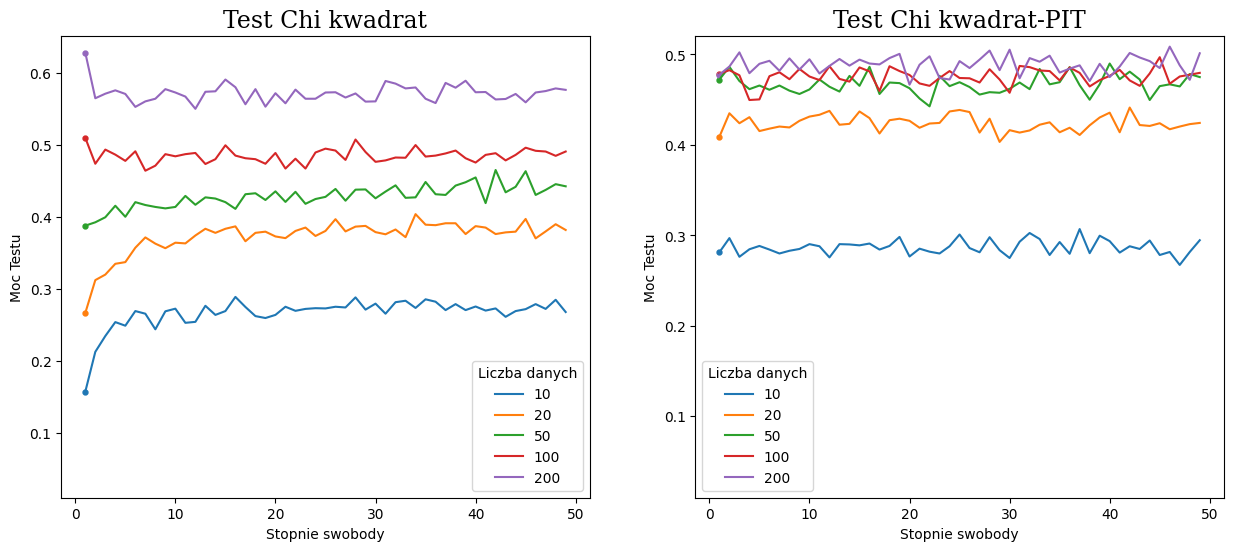

In [ ]:
fig, (chi,chi_pit) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns

# Dodaje dane do wykres
for i,moc in enumerate(moc_chi):
    chi.plot(stopnie_swobody,moc,label= str(liczby_danych[i]))
    chi.scatter(stopnie_swobody[0], moc[0], s=50, marker='.') 

for i,moc in enumerate(moc_chi_pit):
    chi_pit.plot(stopnie_swobody,moc,label= str(liczby_danych[i]))
    chi_pit.scatter(stopnie_swobody[0], moc[0], s=50, marker='.') 


# Dodaje opisy do wykresu test kolgomorowa
chi.set_xlabel("Stopnie swobody")
chi.set_ylabel("Moc Testu")
chi.set_title("Test Chi kwadrat",fontdict=font_title)
chi.legend(title="Liczba danych",loc="lower right")
chi.set_ylim(0.01)



# Dodaje opisy do wykresu 
chi_pit.set_xlabel("Stopnie swobody")
chi_pit.set_ylabel("Moc Testu")
chi_pit.set_title("Test Chi kwadrat-PIT",fontdict=font_title)
chi_pit.legend(title="Liczba danych",loc="lower left")
chi_pit.set_ylim(0.01)




# plt.tight_layout()
plt.show()
